# Assignment 1 - CIC-1205

## Exercise 1 - Loans payment prediction

Student: Balthazar Paixão


## Code


In [2]:
import numpy as np
import pandas as pd

In [3]:
# Defining the column names
colnames = [
    "ESCT",
    "NDEP",
    "RENDA",
    "TIPOR",
    "VBEM",
    "NPARC",
    "VPARC",
    "TEL",
    "IDADE",
    "RESMS",
    "ENTRADA",
    "CLASSE",
]

df_credtrain = pd.read_csv(
    "../class-repo/cic1205/data/credtrain.txt", sep="\t", header=None, names=colnames
)
df_credtest = pd.read_csv(
    "../class-repo/cic1205/data/credtest.txt", sep="\t", header=None, names=colnames
)

In [4]:
# Analyzing the dimensions of the dataframes
print(df_credtrain.shape, df_credtest.shape)

(1500, 12) (577, 12)


In [5]:
df_credtrain.sample(3)

ESCT  NDEP  RENDA  TIPOR  VBEM  NPARC  VPARC  TEL  IDADE  RESMS  \
121      0     0    300      1   459     10     70    0     46      6   
1481     1     0    340      0   340     10     52    0     22     12   
312      1     0    500      0   390      3    145    0     27     48   

      ENTRADA  CLASSE  
121         0       0  
1481        0       1  
312         0       1

### Categorical Features Transformation

The variable ESCT (Civil Status) is categorical, and can assume 4 different values (each value corresponds to a civil status). Note that there is no defined order on these values. For comparison, consider the variable NDEP (which corresponds to the number of dependents of the client).

The presence of categorical variables in a training set can make it difficult to generate the classification model. This is because most learning algorithms (including neural networks) assume the existence of a total order on the values of a variable. To mitigate this problem, an alternative is to transform the ESCT variable into several dummy variables (binary variable). A dummy variable is a binary variable used to represent categories. Thus, the ESCT variable will be transformed into 4 "dummy variants", where the value 1 will correspond to the occurrence of a certain category and the value 0 will correspond to the non-occurrence.


In [6]:
df_credtrain = pd.get_dummies(
    data=df_credtrain, prefix="ESCT", columns=["ESCT"], drop_first=True
)
df_credtest = pd.get_dummies(
    data=df_credtest, prefix="ESCT", columns=["ESCT"], drop_first=True
)

df_credtrain.sample(3)

NDEP  RENDA  TIPOR  VBEM  NPARC  VPARC  TEL  IDADE  RESMS  ENTRADA  \
901      0    400      0   333      4     98    0     54     96        0   
983      0    609      0   830     10    126    0     30      0        0   
1222     0   1548      1   339      6     73    0     63      6        0   

      CLASSE  ESCT_1  ESCT_2  ESCT_3  
901        1   False   False   False  
983        1   False   False   False  
1222       0   False   False   False

In [7]:
# separating the categorical and numerical features in order to apply the scaling and encoder
categorical_features = ["ESCT_1", "ESCT_2", "ESCT_3", "NDEP", "TEL", "TIPOR"]
numerical_features = ["RENDA", "VBEM", "NPARC", "VPARC", "IDADE", "RESMS", "ENTRADA"]


X_train_categories = df_credtrain[categorical_features]
X_train_categories = np.array(X_train_categories).astype(float)
X_train_numerical = df_credtrain[numerical_features]
X_train_numerical = np.array(X_train_numerical).astype(float)
y_train = df_credtrain["CLASSE"]

X_test_categories = df_credtest[categorical_features]
X_test_categories = np.array(X_test_categories).astype(float)
X_test_numerical = df_credtest[numerical_features]
X_test_numerical = np.array(X_test_numerical).astype(float)
y_test = df_credtest["CLASSE"]

### Numerical Feature Scaling

Before training the model, it is also necessary to perform the _normalization_ of the characteristics in order to avoid eventual problems due to the discrepancy in the orders of magnitude of the features.


In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()

X_train_numerical = scaler.fit_transform(X_train_numerical)
X_test_numerical = scaler.transform(X_test_numerical)

X_train = np.concatenate((X_train_categories, X_train_numerical), axis=1)
X_test = np.concatenate((X_test_categories, X_test_numerical), axis=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1500, 13) (577, 13) (1500,) (577,)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

GradientBoostingClassifier()

## Model validation

The metrics for validation that we use here are as follows:

- _precision_ is the percentage of values predicted as positive that are actually positive (1 - customer pay the loan), in relation to the total of predictions (sum of true and false positives). We have this measure also related to the value 0 of the target variable, with analogous definition. This measure basically consists of identifying the proportion of correct predictions of the model, in relation to the total of predictions made.

- _recall_ consists of the following: Among all examples of class 1, what proportion did the model get right. The definition is analogous for examples of class 0. This measure consists of the model's ability to predict a certain target value, i.e., how much it is able to predict 0, and how much it is able to predict 1.

- f1-score is the harmonic mean between recall and precision.

- _support_ is the number of occurrences of examples of a given class. An imbalance in the indicated values can show us that the evaluation measures are still weak. It is not the case, so the measures are reliable. However, if it were the case, perhaps a stratified sampling or a rebalancing in the data would be necessary. Support works as a diagnosis for evaluation.

#### Confusion Matrix

The confusion matrix helps us to see the proportion between errors and hits. The labels "0" and "1" in the lower "margin" of the matrix are the predicted values in each case. Similarly, the labels on the left margin indicate the correct answer.

A diagonal principal, que está colorida em tons de roxo, indica o percentual de previsões corretas para cada classe.

The main diagonal, which is colored in shades of purple, indicates the percentage of correct predictions for each class.

The lighter diagonal indicates the percentage of errors for each class.

We can see that the hit percentages for each class are higher in relation to the error percentages. This is an indication that the model parameters were correctly adjusted during learning.


CLASSIFICATION REPORT - LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       306
           1       0.93      0.82      0.87       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.89      0.89      0.89       577



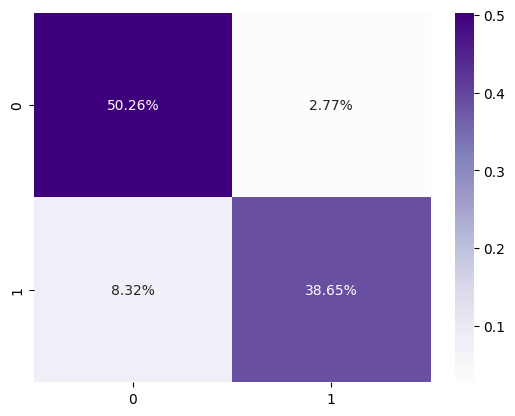

In [16]:
target_names = ["0", "1"]

y_pred_LR = LR.predict(X_test)
print("CLASSIFICATION REPORT - LOGISTIC REGRESSION")
print(classification_report(y_test, y_pred_LR, target_names=target_names))

cm = confusion_matrix(y_test, y_pred_LR)
sns.heatmap(cm / np.sum(cm), annot=True, fmt=".2%", cmap="Purples")
plt.show()

CLASSIFICATION REPORT - DECISION TREE
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       306
           1       0.85      0.87      0.86       271

    accuracy                           0.86       577
   macro avg       0.86      0.87      0.86       577
weighted avg       0.87      0.86      0.86       577



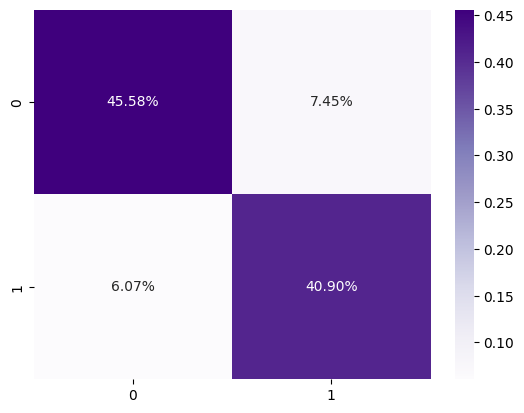

In [17]:
y_pred_DT = DT.predict(X_test)
print("CLASSIFICATION REPORT - DECISION TREE")
print(classification_report(y_test, y_pred_DT, target_names=target_names))

cm = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(cm / np.sum(cm), annot=True, fmt=".2%", cmap="Purples")
plt.show()

CLASSIFICATION REPORT - RANDOM FOREST
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       306
           1       0.94      0.82      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577



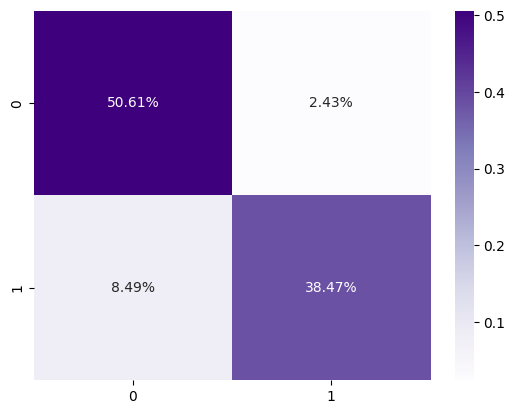

In [18]:
y_pred_RF = RF.predict(X_test)
print("CLASSIFICATION REPORT - RANDOM FOREST")
print(classification_report(y_test, y_pred_RF, target_names=target_names))

cm = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(cm / np.sum(cm), annot=True, fmt=".2%", cmap="Purples")
plt.show()

CLASSIFICATION REPORT - KNN
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       306
           1       0.87      0.80      0.83       271

    accuracy                           0.85       577
   macro avg       0.85      0.85      0.85       577
weighted avg       0.85      0.85      0.85       577



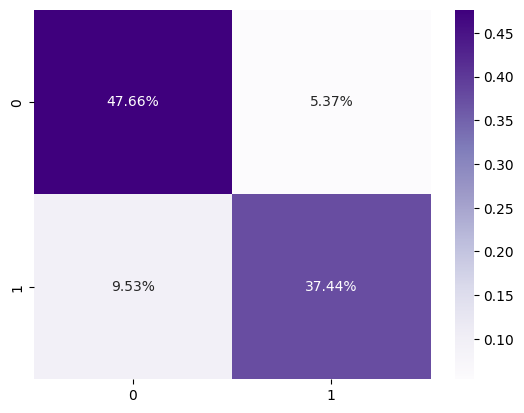

In [19]:
y_pred_KNN = KNN.predict(X_test)
print("CLASSIFICATION REPORT - KNN")
print(classification_report(y_test, y_pred_KNN, target_names=target_names))

cm = confusion_matrix(y_test, y_pred_KNN)
sns.heatmap(cm / np.sum(cm), annot=True, fmt=".2%", cmap="Purples")
plt.show()

In [20]:
y_pred_GB = GB.predict(X_test)
print("CLASSIFICATION REPORT - GRADIENT BOOSTING")
print(classification_report(y_test, y_pred_GB, target_names=target_names))

cm = confusion_matrix(y_test, y_pred_GB)
sns.heatmap(cm / np.sum(cm), annot=True, fmt=".2%", cmap="Purples")
plt.show()

CLASSIFICATION REPORT - GRADIENT BOOSTING
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       306
           1       0.96      0.83      0.89       271

    accuracy                           0.90       577
   macro avg       0.91      0.90      0.90       577
weighted avg       0.91      0.90      0.90       577

